In [56]:
import matplotlib.pyplot as plt
import cirq
import numpy as np
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import sympy as sp
import pandas as pd

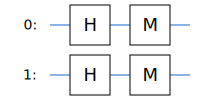

In [57]:
circuit = cirq.Circuit()

qubits = cirq.LineQubit.range(2)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.measure(qubits[0]))
circuit.append(cirq.measure(qubits[1]))

SVGCircuit(circuit)

q(0)=1010110011
q(1)=1001100101


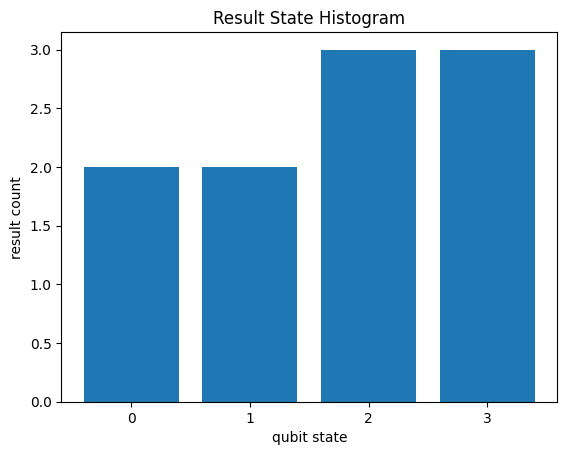

In [58]:
sim = cirq.Simulator()
samples = sim.run(circuit, repetitions = 10)

print(samples)

cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

## 1. Initialization Problem - Max cut
3 nodes, 2 vertices, H2O like figure Max Cut problem and Hamiltonian

In [318]:
# Weight Block
# Define adjacency matrix

weight000 = np.array([
    [0, 1, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])

# 채찍피티 max cut problem
weight111 = np.array([
    [0, 2, 0, 7, 0, 0, 0, 4, 0, 0],
    [2, 0, 6, 0, 0, 0, 0, 0, 9, 1],
    [0, 6, 0, 0, 3, 8, 0, 0, 0, 0],
    [7, 0, 0, 0, 5, 0, 1, 0, 0, 0],
    [0, 0, 3, 5, 0, 0, 0, 0, 0, 4],
    [0, 0, 8, 0, 0, 0, 6, 0, 0, 0],
    [0, 0, 0, 1, 0, 6, 0, 3, 0, 0],
    [4, 0, 0, 0, 0, 0, 3, 0, 0, 2],
    [0, 9, 0, 0, 0, 0, 0, 0, 0, 5],
    [0, 1, 0, 0, 4, 0, 0, 2, 5, 0]
])

weight0 = np.array([ [0, 1], [1, 0] ])
weight1 = np.array([ [0, 1], [1, 0] ])
weight2 = np.array([ [0, -1], [-1, 0] ])

typ = ["Na", "Cl"]; typ_n = len(typ) 
pos = [0, 1]; pos_n = len(pos)

print(weight)

[[0 2 0 7 0 0 0 4 0 0]
 [2 0 6 0 0 0 0 0 9 1]
 [0 6 0 0 3 8 0 0 0 0]
 [7 0 0 0 5 0 1 0 0 0]
 [0 0 3 5 0 0 0 0 0 4]
 [0 0 8 0 0 0 6 0 0 0]
 [0 0 0 1 0 6 0 3 0 0]
 [4 0 0 0 0 0 3 0 0 2]
 [0 9 0 0 0 0 0 0 0 5]
 [0 1 0 0 4 0 0 2 5 0]]


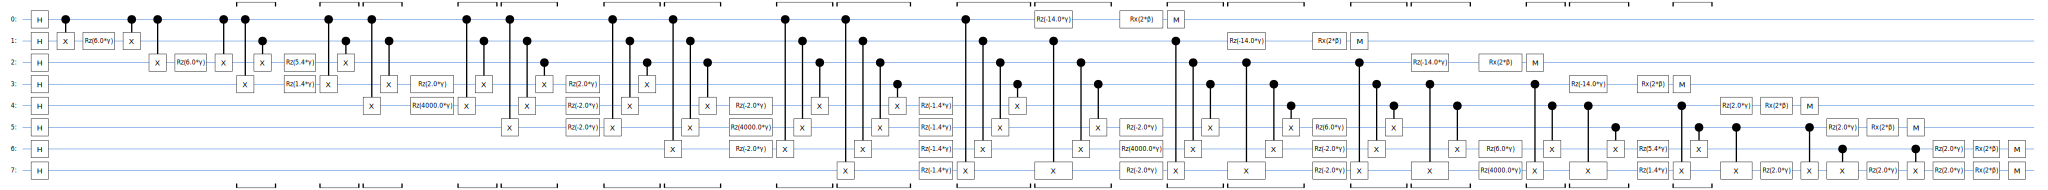

In [309]:
# Linequbit number of nodes
node = weight.shape[0] # this is maxcut node

# Define symbolic parameters
gamma = sp.Symbol("γ")
beta = sp.Symbol("β")

# Create qubits and initialize circuit
qubits = cirq.LineQubit.range(node)
qaoa_circuit = cirq.Circuit()

# Initial Hadamard layer
qaoa_circuit.append([cirq.H(q) for q in qubits])
def cirqzz(qubits, weight, i, j):
    return [cirq.CNOT(qubits[i], qubits[j]), cirq.rz(2 * gamma * weight[i, j])(qubits[j]), cirq.CNOT(qubits[i], qubits[j])]
            
# Cost Hamiltonian layer (ZZ interactions)
for i in range(node):
    for j in range(i+1, node):
        if weight[i, j] != 0:
            qaoa_circuit.append(cirqzz(qubits, weight, i, j))
            # qaoa_circuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (2 * gamma * weight[i, j]))

# Self Ineraction term
for i in range(node):
    if weight[i, i] != 0:
        qaoa_circuit.append(cirq.rz(2 * gamma * weight[i, i])(qubits[i]))

# Mixer layer (Rx rotations applied in parallel)
qaoa_circuit.append([cirq.rx(2 * beta)(q) for q in qubits])

# Measurement layer
qaoa_circuit.append([
    cirq.measure(q) for q in qubits
])

# Visualize the circuit
SVGCircuit(qaoa_circuit)

## 2. Cost Calculation function and Simple Simulation

In [310]:
def estimate_cost(weight, samples):
    cost_value = 0.0
    node = weight.shape[0]

    # Loop over upper triangle of adjacency matrix
    for i in range(node):
        for j in range(i, node):
            if weight[i, j] != 0:
                i_samples = samples["q(" + str(i) + ")"]
                j_samples = samples["q(" + str(j) + ")"]

                # Convert {0,1} to {+1, -1}
                i_signs = (-1) ** i_samples
                j_signs = (-1) ** j_samples
                term_signs = i_signs * j_signs

                # Expectation value for edge (i,j)
                term_val = np.mean(term_signs) * weight[i, j]
                cost_value += term_val

    return cost_value

In [311]:
gamma_value = np.pi / 4
beta_value = np.pi / 2
sim = cirq.Simulator()

sample_results = sim.sample(qaoa_circuit, params={gamma: gamma_value, beta: beta_value}, repetitions=20000)

sample_results = dict(sample_results)

print(f"Gamma = {round(gamma_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(weight, sample_results)}")

Gamma = 0.785 Beta = 1.571
Estimated cost: -19.443099999999998


## 3. Iteration over zero to pi values to gamma and beta

In [312]:
import time

start = time.time()
grid_size = 11

def gam_beta_grid(weight, grid_size):
    grid = np.zeros((grid_size, grid_size))
    gamma_sweep = np.linspace(0, np.pi, grid_size)
    print(gamma_sweep)
    beta_sweep = np.linspace(0, np.pi, grid_size)
    print(beta_sweep)
    
    for i in range(grid_size):
        for j in range(grid_size):
            results = sim.sample(qaoa_circuit, params = {gamma : gamma_sweep[i], beta : beta_sweep[j]}, repetitions = 20000)
            results = dict(results)
            cost = estimate_cost(weight, results)
            grid[i, j] = cost
            
    mini, maxi = np.min(grid), np.max(grid)
    min_g, min_b = np.unravel_index(np.argmin(grid), grid.shape)
    min_gam = gamma_sweep[min_g] 
    # https://i.namu.wiki/i/f_q_IqI70RTqi_uiV4x62Y-pB--aJj6WUpDc-JMMTPL8x98fa_RVinXWilRrq6VabEc5WHLo3z3ME6APjRZDgOgHUhwPULFa3XT5P29OSMtr3saevTIeqrjORaZRqBIR1Teb9sSmhi7vB4u4ITUxGw.webp
    min_bet = beta_sweep[min_b]
    return mini, maxi, min_gam, min_bet, grid
        
mini, maxi, min_gam, min_bet, grid = gam_beta_grid(weight, grid_size)
print(mini, maxi, min_gam, min_bet)


end = time.time()

print(end - start)

[0.         0.31415927 0.62831853 0.9424778  1.25663706 1.57079633
 1.88495559 2.19911486 2.51327412 2.82743339 3.14159265]
[0.         0.31415927 0.62831853 0.9424778  1.25663706 1.57079633
 1.88495559 2.19911486 2.51327412 2.82743339 3.14159265]
-3282.5267400000007 873.85468 1.5707963267948966 0.6283185307179586
27.393067598342896


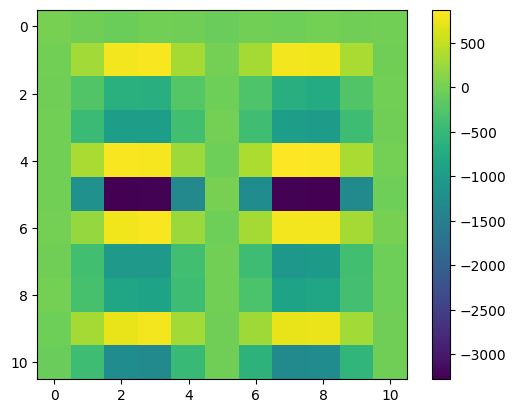

In [313]:
plt.imshow(grid)
plt.colorbar()
plt.show()

## 4. Calculation and Qubit statistic about optimized gamma and beta

In [314]:
gamma_value = min_gam
beta_value = min_bet
sim = cirq.Simulator()

sample_results = sim.sample(
    qaoa_circuit, params={gamma: gamma_value, beta: beta_value}, repetitions=200000
)

sample_results = dict(sample_results)
a = sample_results["q(0)"][5]
print(a)

print(f"Gamma = {round(gamma_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(weight, sample_results)}")

0
Gamma = 1.571 Beta = 0.628
Estimated cost: -3284.52415


In [315]:
def histogram_qubits(result, node, repetition):
    qubit_list = {}
    str_qubit = ["q(" + str(i) + ")" for i in range(node)]
    for idx in range(repetition):
        res_qubit = ""
        for jdx in str_qubit:
            res_qubit += str(result[jdx][idx])

        try:
            qubit_list[res_qubit] += 1
        except:
            qubit_list[res_qubit] = 1

    return qubit_list

['01101001', '10010110', '11110000', '00001111', '01111000', '11010010', '11100001', '00011110', '00101101', '01001011', '10000111', '10110100', '01001001', '01001111', '11110010', '10010010', '00010110', '00001101', '00001110', '11010000'] [8258, 8161, 8079, 8067, 2659, 2577, 2570, 2568, 2563, 2538, 2516, 2514, 1859, 1808, 1808, 1798, 1795, 1787, 1787, 1784]


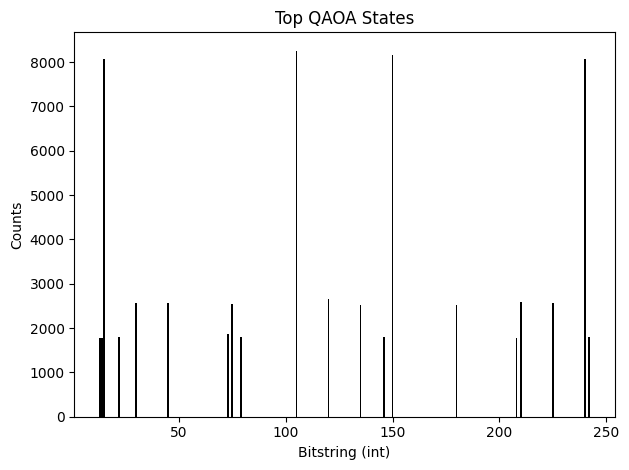

In [316]:
qubit_list = histogram_qubits(sample_results, node, 200000)
sorted_qubit_list = dict(sorted(qubit_list.items(), key=lambda x: x[0]))
sorted_qubit_list = {int(k, 2): v for k, v in sorted_qubit_list.items()}
ranking_qubit_list = dict(sorted(qubit_list.items(), key=lambda x: x[1], reverse=True))
# print(ranking_qubit_list)
compo = list(ranking_qubit_list.keys())
count = list(ranking_qubit_list.values())
print(compo[0:20], count[0:20])

sym = sorted_qubit_list.keys()
val = sorted_qubit_list.values()
top_N = 20
top_keys = list(ranking_qubit_list.keys())[:top_N]
top_vals = list(ranking_qubit_list.values())[:top_N]
top_keys_int = [int(k, 2) for k in top_keys]

plt.bar(top_keys_int, top_vals, color="black")
plt.title("Top QAOA States")
plt.xlabel("Bitstring (int)")
plt.ylabel("Counts")
plt.tight_layout()
plt.savefig(f"result/{name}_top{top_N}.png")
plt.show()